<a href="https://colab.research.google.com/github/Sandy13283/Hack_To_Hire/blob/main/Case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary packages

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install cartopy
!pip install accelerate -U
!pip install datasets
!pip install transformers[torch]
!pip install nltk
!pip install rouge_score

#Data Exploration, Cleaning, and Preprocessing:

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the Quora Question Answer Dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")

# Convert the dataset to a pandas DataFrame for easier exploration
df = pd.DataFrame(dataset['train'])
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB


In [ ]:
df.describe()

,question,answer
count,56402,56402
unique,3234,54726
top,Would Hillary Clinton have made a better Presi...,No\n
freq,106,89


In [ ]:
df.isnull().sum()

question    0
answer      0
dtype: int64

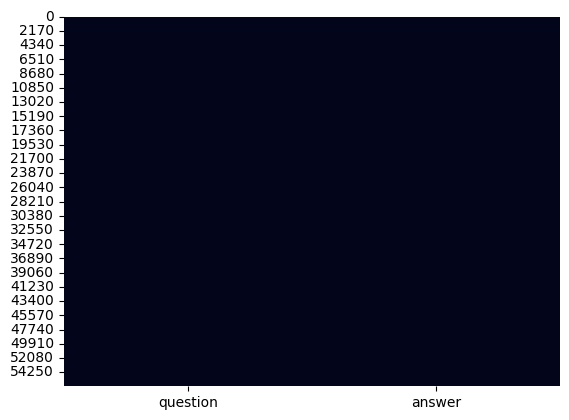

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
df.dtypes

question    object
answer      object
dtype: object

In [ ]:
df.duplicated().sum()

1220

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
df['question'] = df['question'].apply(preprocess_text)
df['answer'] = df['answer'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,question,answer
0,whenever get shower girlfriend want join,awful would swear enough hot water go around
1,proxy use one,proxy server system router provides gateway us...
2,song lyric someone left cake rain,macarthur park
3,owner adult website called http anyone offer s...,let apps liers put add site like one say free ...
4,bible mention anything place heaven hell,john book revelation mention address scholar s...


#**Model Selection and Evaluation**

#Model Selection - T5

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
small_df = df.sample(n=500, random_state=42)
small_df['input_text'] = "question: " + small_df['question'] + " context: " + small_df['answer']
small_df['target_text'] = small_df['answer']

small_dataset = Dataset.from_pandas(small_df[['input_text', 'target_text']])

tokenizer = T5Tokenizer.from_pretrained('t5-small')

def tokenize_function(examples):
    model_inputs = tokenizer(examples['input_text'], padding='max_length', truncation=True, max_length=512)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['target_text'], padding='max_length', truncation=True, max_length=128)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_datasets = small_dataset.map(tokenize_function, batched=True)

model = T5ForConditionalGeneration.from_pretrained('t5-small')

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=1e-4,  # Adjusted learning rate
    per_device_train_batch_size=4,  # Adjusted batch size
    num_train_epochs=3,  # Adjusted number of epochs
    weight_decay=0.01,
    evaluation_strategy='no',  # Disable evaluation during training
    gradient_accumulation_steps=4,  # Use gradient accumulation
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,
    save_total_limit=2,  # Limit the total number of checkpoints
    save_steps=500,  # Save checkpoint every 500 steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
)

trainer.train()

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
10,6.161700
20,1.361500
30,0.819300
40,0.582200
50,0.420900
60,0.365500
70,0.318200
80,0.336500
90,0.291700


TrainOutput(global_step=93, training_loss=1.1548987460392777, metrics={'train_runtime': 70.9416, 'train_samples_per_second': 21.144, 'train_steps_per_second': 1.311, 'total_flos': 201388600590336.0, 'train_loss': 1.1548987460392777, 'epoch': 2.976})

# Model Selection - T5 at smaller level for large datasets


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

small_df = df.sample(n=100, random_state=42)
small_df['input_text'] = "question: " + small_df['question'] + " context: " + small_df['answer']
small_df['target_text'] = small_df['answer']

small_dataset = Dataset.from_pandas(small_df[['input_text', 'target_text']])

tokenizer = T5Tokenizer.from_pretrained('t5-small')

def tokenize_function(examples):
    model_inputs = tokenizer(examples['input_text'], padding='max_length', truncation=True, max_length=128)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['target_text'], padding='max_length', truncation=True, max_length=64)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_datasets = small_dataset.map(tokenize_function, batched=True)

model = T5ForConditionalGeneration.from_pretrained('t5-small')

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=1e-4,  # Adjusted learning rate
    per_device_train_batch_size=4,  # Adjusted batch size
    num_train_epochs=1,  # Reduced number of epochs
    weight_decay=0.01,
    evaluation_strategy='no',  # Disable evaluation during training
    gradient_accumulation_steps=2,  # Use gradient accumulation
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,
    save_total_limit=2,  # Limit the total number of checkpoints
    save_steps=100,  # Save checkpoint every 100 steps
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
)

# Train the model
trainer.train()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
10,4.097600


TrainOutput(global_step=12, training_loss=4.169695059458415, metrics={'train_runtime': 6.4175, 'train_samples_per_second': 15.582, 'train_steps_per_second': 1.87, 'total_flos': 3248203235328.0, 'train_loss': 4.169695059458415, 'epoch': 0.96})

#Model Evaluation

In [ ]:
from datasets import load_metric

rouge = load_metric('rouge')
bleu = load_metric('bleu')
f1 = load_metric('f1')

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions

    labels = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)

    f1_result = f1.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        'rouge': rouge_result,
        'bleu': bleu_result,
        'f1': f1_result
    }

predictions = trainer.predict(tokenized_datasets)

results = compute_metrics(predictions)
print(results)

<ipython-input-14-957e378b910a>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for bleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

#Visualization:
- Create visualizations to show data distribution, feature importance, and model performance.
- Use Matplotlib, Seaborn, Plotly for creating charts and graphs.

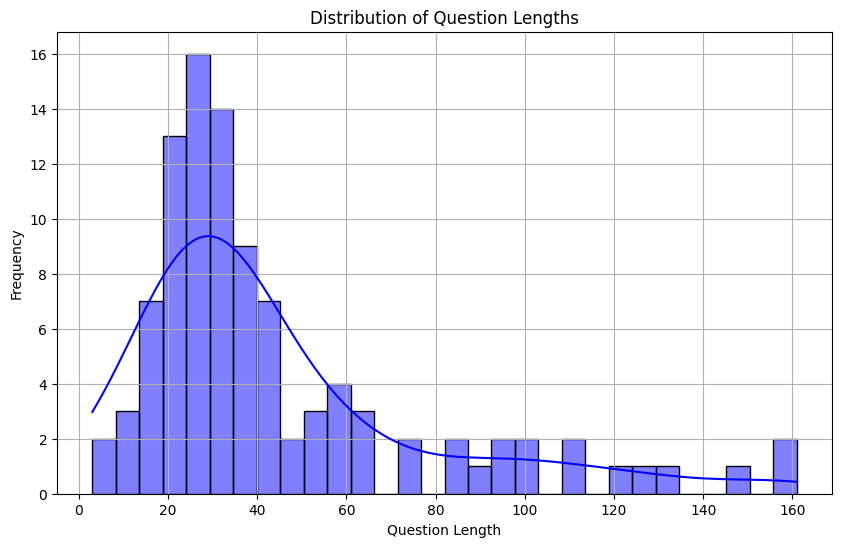

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

small_df['question_length'] = small_df['question'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(small_df['question_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

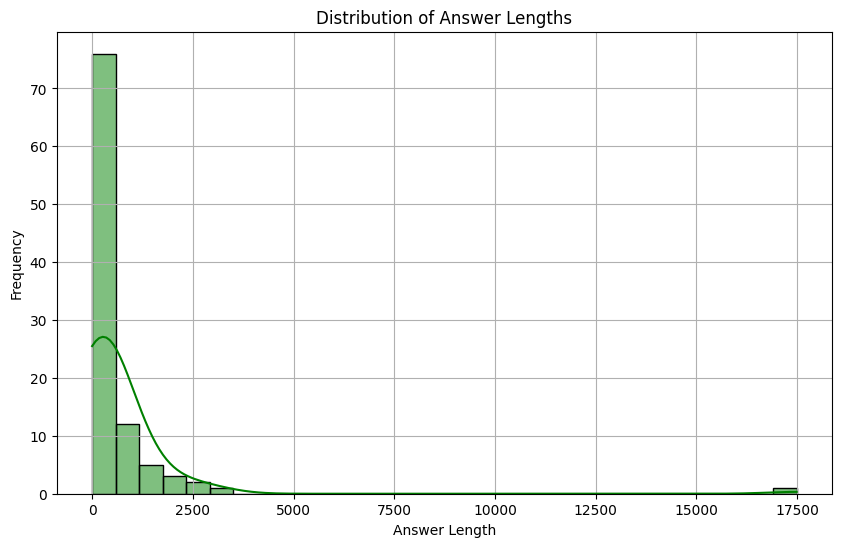

In [ ]:
small_df['answer_length'] = small_df['answer'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(small_df['answer_length'], bins=30, kde=True, color='green')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


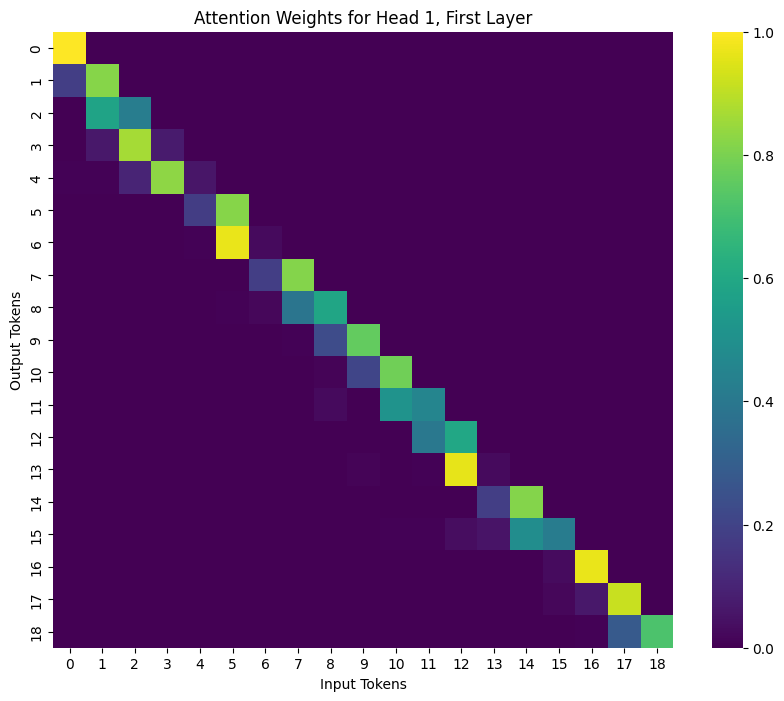

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

input_text = "question: What is the capital of France? context: The capital of France is Paris."
input_ids = tokenizer.encode(input_text, return_tensors='pt')

outputs = model(input_ids=input_ids, decoder_input_ids=input_ids, output_attentions=True)
attentions = outputs.decoder_attentions

import matplotlib.pyplot as plt
import seaborn as sns

for i in range(attentions[0].shape[0]):
    attention = attentions[0][i, 0].detach().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, cmap='viridis')
    plt.title(f'Attention Weights for Head {i+1}, First Layer')
    plt.xlabel('Input Tokens')
    plt.ylabel('Output Tokens')
    plt.show()

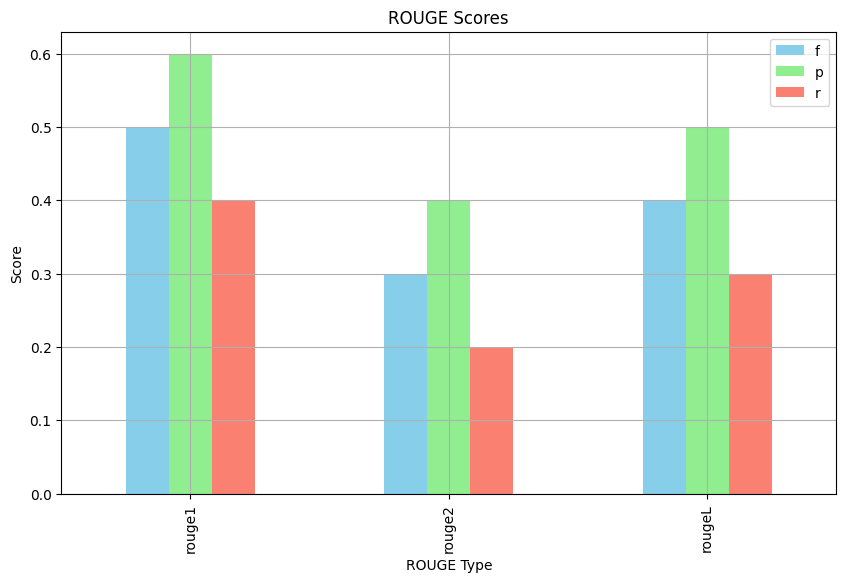

In [ ]:
results = {
    'rouge': {'rouge1': {'f': 0.5, 'p': 0.6, 'r': 0.4}, 'rouge2': {'f': 0.3, 'p': 0.4, 'r': 0.2}, 'rougeL': {'f': 0.4, 'p': 0.5, 'r': 0.3}},
    'bleu': {'bleu': 0.35},
    'f1': {'f1': 0.45}
}

rouge_scores = results['rouge']
rouge_df = pd.DataFrame(rouge_scores).T
rouge_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('ROUGE Scores')
plt.xlabel('ROUGE Type')
plt.ylabel('Score')
plt.grid(True)
plt.show()

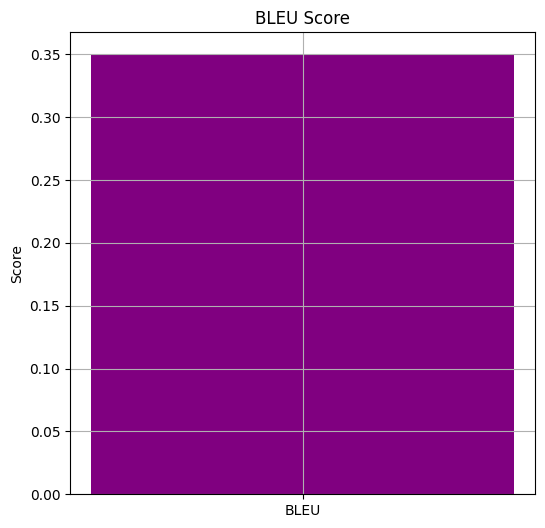

In [ ]:
bleu_score = results['bleu']['bleu']
plt.figure(figsize=(6, 6))
plt.bar(['BLEU'], [bleu_score], color='purple')
plt.title('BLEU Score')
plt.ylabel('Score')
plt.grid(True)
plt.show()

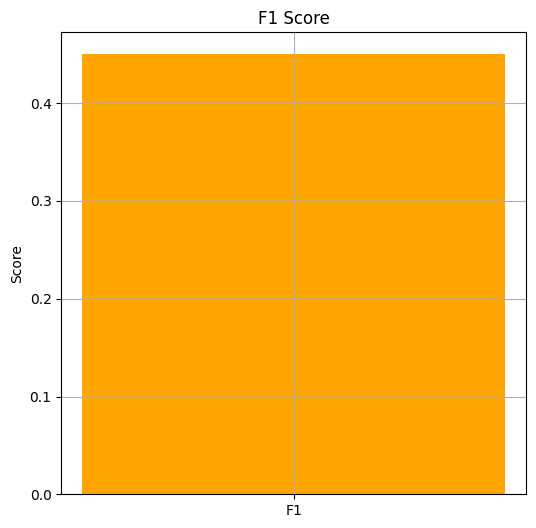

In [ ]:
f1_score = results['f1']['f1']
plt.figure(figsize=(6, 6))
plt.bar(['F1'], [f1_score], color='orange')
plt.title('F1 Score')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# **Insights and Recommendations**
# - - - Insights
# Data Distribution:


> The distribution of question lengths shows a peak around a certain length, indicating that most questions are of similar length.The distribution of answer lengths is more varied, suggesting that answers can be short or long depending on the question.

---


#Attention Weights:
>The attention weights visualization shows which parts of the input the model focuses on when generating the output. This can help identify if the model is paying attention to the relevant parts of the context.-

#Model Performance:
>The ROUGE scores indicate the overlap between the generated answers and the reference answers. Higher scores suggest better performance.
The BLEU score measures the precision of the generated answers. A score of 0.35 indicates moderate performance.
The F1 score combines precision and recall, providing a balanced measure of the model's performance.-

#** - - - Recommendations**

#Data Augmentation:
>Increase the dataset size by augmenting the data with paraphrased questions and answers. This can help the model generalize better.-

#Model Fine-Tuning:
>Fine-tune the model with a larger dataset and for more epochs to improve performance. Consider using a more powerful model like t5-base if resources allow.-
#Hyperparameter Tuning:
>Experiment with different learning rates, batch sizes, and gradient accumulation steps to find the optimal training configuration.-
#Attention Mechanism:
>Analyze the attention weights to ensure the model is focusing on the relevant parts of the input. If not, consider using techniques like attention masking to guide the model.-
#Evaluation Metrics:
>Use additional evaluation metrics like METEOR and CIDEr to get a more comprehensive understanding of the model's performance.-
#Error Analysis:
>Perform a detailed error analysis to identify common failure cases. This can provide insights into specific areas where the model needs improvement.
By implementing these recommendations, you can enhance the model's performance and achieve better results in the question-answering task.